In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb 
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import h3
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from haversine import haversine, Unit
from statsmodels.stats.weightstats import ztest
import missingno as msno
from scipy.stats import chi2_contingency
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import joblib


In [5]:
df = pd.read_csv('part2-dataset.csv')

/tmp/ipykernel_220473/892854130.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('part2-dataset.csv')


In [6]:
fraud = pd.read_csv('part2-fraud-sample.csv')

In [7]:
df.head()

,Unnamed: 0,created_date,customer_id,biker_request_id,biker_phone_number,order_request_id,city,delivery_category_id,customer_ref_id,final_status,biker_fare_per_terminal,customer_phone_number,destination_longitude,destination_latitude,source_latitude,source_longitude
0,0,2023-08-03,11653225,1305684.0,f0xsz+2AwzyE5upJoZiRPg==,476979798,mashhad,2,d0584bd9-3faf-4548-9524-2301c6b53477,DELIVERED,110000.0,IJ/G/FCku4VmMc0ysmeljQ==,27.182306,21.339714,21.335510,27.184477
1,1,2023-08-03,11653225,17520.0,HhcTOAXS3fjGB8qV56pvsA==,473276458,mashhad,2,f88d3cc4-c855-4f64-8d68-76d169c1f208,DELIVERED,180000.0,bcTH3WaJCXBpue89a8nY/Q==,27.346241,21.374972,21.372564,27.347296
2,2,2023-08-03,11653225,2642406.0,MsBIgqhcHug2ABwrs/NpBw==,475854199,mashhad,2,a5d029ea-fb97-4617-9d65-cb921f535564,DELIVERED,40000.0,Zu0mYA6iyC/YKiweS93tqg==,27.184062,21.331320,21.331901,27.183952
3,3,2023-08-03,11653225,2909573.0,sMFPNzhcZLFq5qUlA6hkYg==,477350228,mashhad,2,b4d252eb-1b73-4094-a54f-612cb8c87eda,DELIVERED,345000.0,0qabDebg/QgYtAdbErDsgw==,27.345351,21.376528,21.376674,27.350910
4,4,2023-08-03,11653225,2285206.0,rPKRNUD0f0ivPb5PIxIVNw==,476319552,mashhad,2,7eb32010-e262-4b93-bd4f-4ca6008ea60d,DELIVERED,420000.0,0qabDebg/QgYtAdbErDsgw==,27.383733,21.349205,21.346586,27.385021


In [8]:
fraud.head()

,Unnamed: 0,created_date,customer_id,reason,biker_request_id,biker_phone_number,order_request_id,city,delivery_category,customer_ref_id,final_status,biker_fare_per_terminal,customer_phone_number,destination_longitude,destination_latitude,source_latitude,source_longitude
0,92,2023-08-03,2,same_biker_same_customer,2997747,DdYkRZO6s/7+wAqt/ykX4Q==,476519902,mashhad,big-box,424438625,DELIVERED,162500.000000,DdYkRZO6s/7+wAqt/ykX4Q==,27.374180,21.347616,21.347160,27.368386
1,478,2023-08-08,11653225,fake ride,2948946,ELJeQx5rxhhEmfHwgA5OYw==,477901383,mashhad,bike-without-box,9587ae55-7fe6-4ce3-a3d3-5318aea99f5b,DELIVERED,180000.000000,fAhijISaQLNNfvt2Epm7Lw==,27.372249,21.363878,21.363502,27.372126
2,328,2023-08-06,14109185,fake ride,2996281,Ye3KL4SuOSsObrqLQEpzmw==,472410620,mashhad,bike-without-box,13783376,DELIVERED,413333.333333,ql+OWn4d094Dv+qGekHDyg==,27.366596,21.353237,21.353792,27.366384
3,218,2023-08-05,11653225,fake ride,2007528,F9W4mmmFG3vs3WYeRlmx8g==,472812665,mashhad,bike-without-box,42d55f08-068f-43d4-87e5-a61b21277dc3,DELIVERED,80000.000000,qZTnfP8YOg40wBZ2DnB57w==,27.368057,21.351640,21.351580,27.368103
4,387,2023-08-07,11653225,fake ride,3209726,s1FugjWvloZA+ZftOJmFJQ==,475974765,mashhad,bike-without-box,98450165-3f2c-4dc2-833e-eda0d2f02edd,DELIVERED,160000.000000,6xiri9b2vdfrbLxkZLkIZw==,27.367335,21.364569,21.364643,27.367372


## Statistical analysis

In [82]:
def histogram_plot(data, xlabel, statistics, kde = False):
    mean_value = np.mean(data)
    median_value = np.median(data)

    sb.histplot(data, bins=30, kde=kde, color='blue', alpha=0.5, edgecolor='black')
    
    if statistics:
        plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2)
        plt.text(mean_value, plt.ylim()[1]*0.95, 'Mean: {:.2f}'.format(mean_value), color = 'red')

        plt.axvline(median_value, color='green', linestyle='dashed', linewidth=2)
        plt.text(median_value, plt.ylim()[1]*0.90, 'Median: {:.2f}'.format(median_value), color = 'green')

    plt.title('Histogram')
    plt.xlabel(xlabel)
    plt.ylabel('Frequency / Probability Density')

    plt.show()

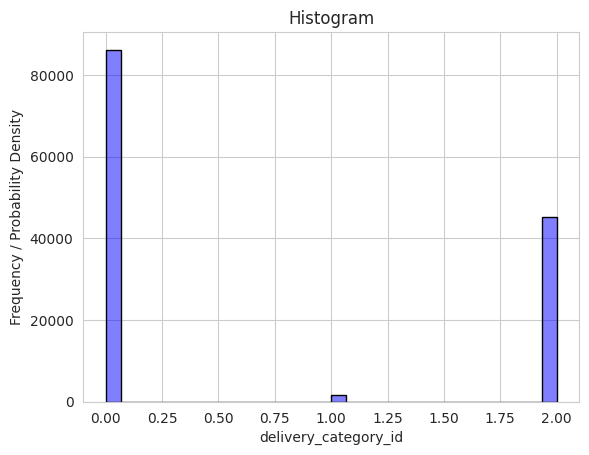

In [83]:
histogram_plot(df['delivery_category_id'],'delivery_category_id',statistics=False, kde = False)

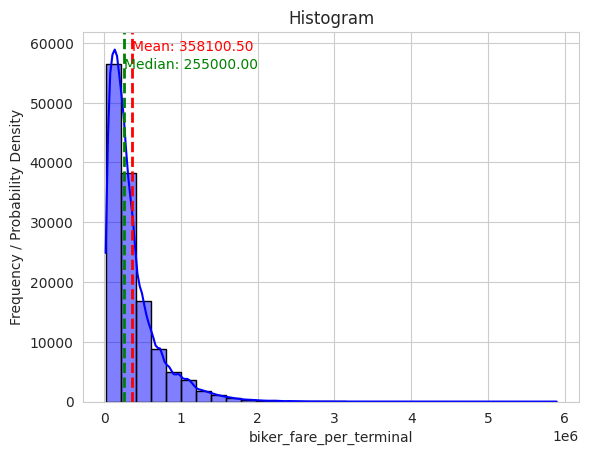

In [85]:
histogram_plot(df['biker_fare_per_terminal'],'biker_fare_per_terminal',statistics=True,kde = True)

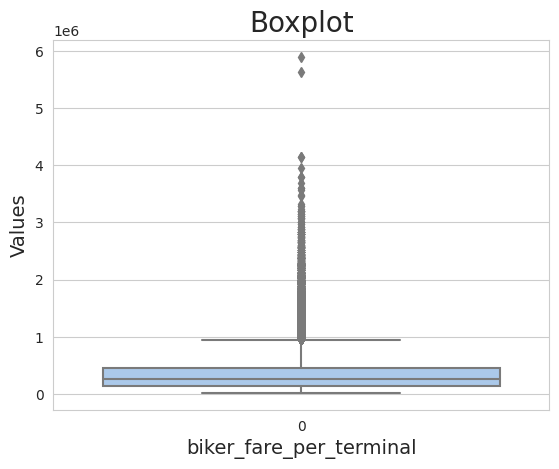

In [12]:
sb.set_style("whitegrid")


sb.boxplot(data=df['biker_fare_per_terminal'], palette="pastel")

plt.title('Boxplot', fontsize=20)
plt.xlabel('biker_fare_per_terminal', fontsize=14)
plt.ylabel('Values', fontsize=14)

plt.show()

In [13]:
df['customer_id'].value_counts()

customer_id
2           83996
11653225    50366
Name: count, dtype: int64

In [14]:
df['created_date'].value_counts()

created_date
2023-08-11    16105
2023-08-09    16082
2023-08-10    15970
2023-08-07    14986
2023-08-05    14930
2023-08-08    14662
2023-08-03    14184
2023-08-04    13945
2023-08-06    13498
Name: count, dtype: int64

In [15]:
df['order_request_id'].value_counts()

order_request_id
478507310    3
471312806    3
478192445    3
478984651    3
474925665    3
            ..
473249835    1
474072657    1
475078968    1
475372797    1
469579910    1
Name: count, Length: 130914, dtype: int64

In [16]:
df[df['order_request_id']==478507310]

,Unnamed: 0,created_date,customer_id,biker_request_id,biker_phone_number,order_request_id,city,delivery_category_id,customer_ref_id,final_status,biker_fare_per_terminal,customer_phone_number,destination_longitude,destination_latitude,source_latitude,source_longitude
103760,103760,2023-08-07,2,1851001.0,XL8c2ntVZ5C3AFBsKK8qyA==,478507310,mashhad,0,424905836,DELIVERED,960000.0,v1Ten8pejx1wJup23jqrTQ==,27.345486,21.368949,21.368949,27.345475
103796,103796,2023-08-07,2,1851001.0,XL8c2ntVZ5C3AFBsKK8qyA==,478507310,mashhad,0,424905847,DELIVERED,300000.0,v1Ten8pejx1wJup23jqrTQ==,27.345484,21.368927,21.368949,27.345475
103884,103884,2023-08-07,2,1851001.0,XL8c2ntVZ5C3AFBsKK8qyA==,478507310,mashhad,0,424905866,DELIVERED,480000.0,v1Ten8pejx1wJup23jqrTQ==,27.345484,21.368927,21.368949,27.345475


In [17]:
fraud['reason'].value_counts()

reason
fake ride                   78
same_biker_same_customer    22
Name: count, dtype: int64

In [18]:
fraud['final_status'].value_counts()

final_status
DELIVERED    100
Name: count, dtype: int64

In [19]:
df['final_status'].value_counts()

final_status
DELIVERED    133146
CANCELLED      1216
Name: count, dtype: int64

In [20]:
df['city'].value_counts()

city
mashhad    134362
Name: count, dtype: int64

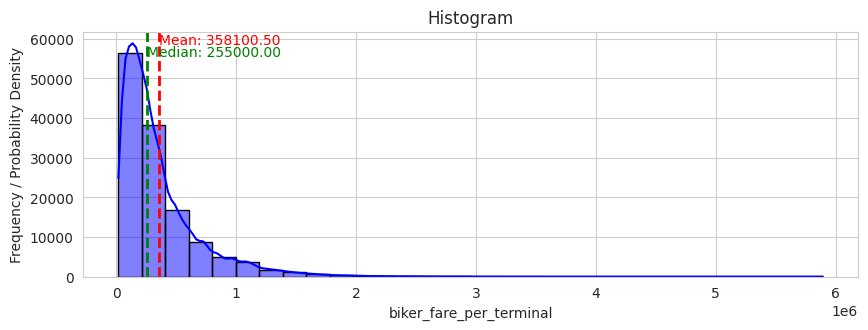

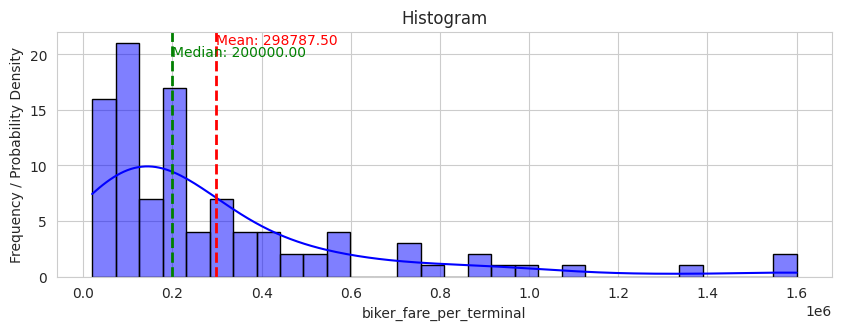

In [86]:
plt.figure(figsize=(10,7))
plt.subplot(2,1,1)
histogram_plot(df['biker_fare_per_terminal'],'biker_fare_per_terminal',statistics=True,kde = True)
plt.figure(figsize=(10,7))

plt.subplot(2,1,2)
histogram_plot(fraud['biker_fare_per_terminal'],'biker_fare_per_terminal',statistics=True,kde = True)


In [22]:
df.isna().sum()

Unnamed: 0                    0
created_date                  0
customer_id                   0
biker_request_id           1224
biker_phone_number         1224
order_request_id              0
city                          0
delivery_category_id          0
customer_ref_id               0
final_status                  0
biker_fare_per_terminal       0
customer_phone_number         0
destination_longitude         0
destination_latitude          0
source_latitude               0
source_longitude              0
dtype: int64

<Axes: >

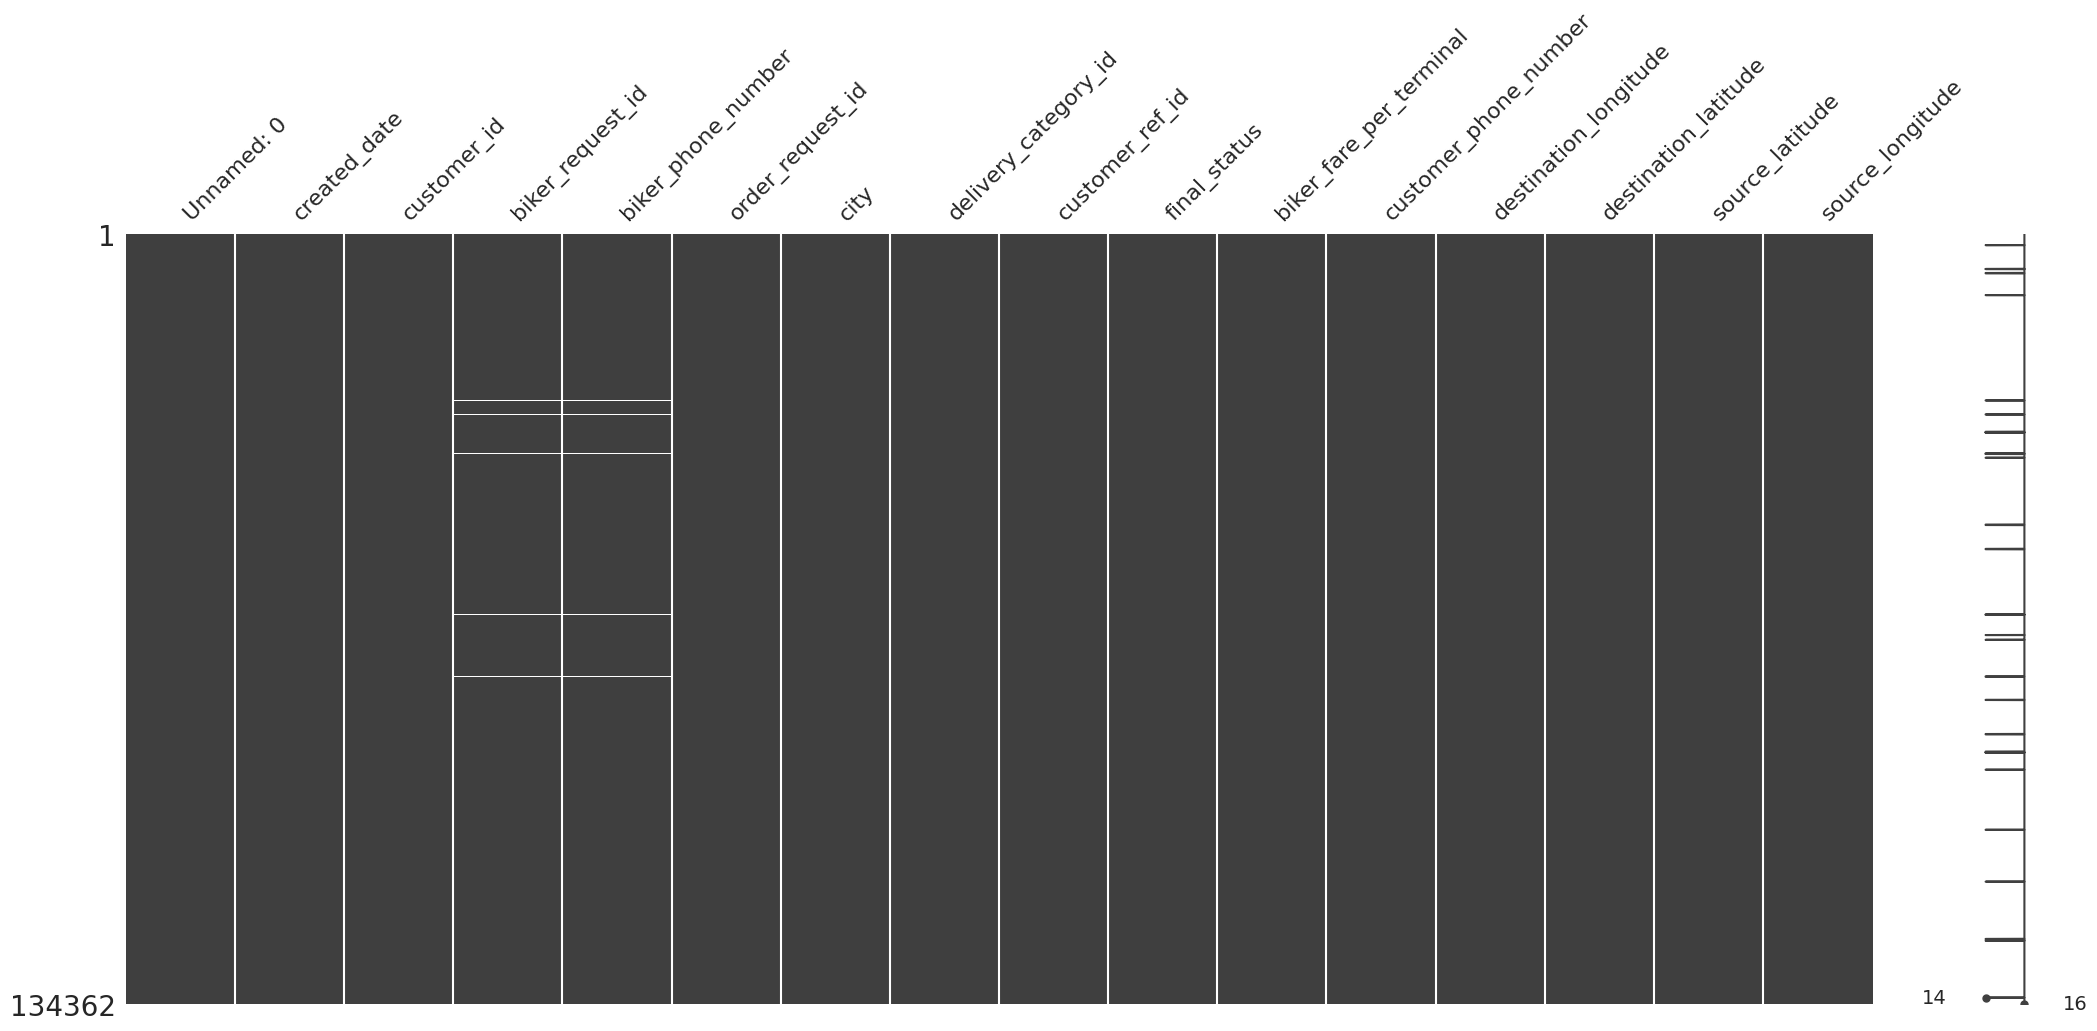

In [23]:

msno.matrix(df)


In [24]:
df.drop(columns=['Unnamed: 0','city'],inplace = True)

In [25]:
df['missing_indicator'] = df['biker_phone_number'].isnull().astype(int)

results = []

for column in df.columns:
    print(column)
    if column not in ['biker_phone_number', 'missing_indicator']: 
        contingency_table = pd.crosstab(df['missing_indicator'], df[column])
        
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        
        results.append({'Feature': column, 'Chi2 Statistic': chi2, 'p-value': p})



created_date
customer_id
biker_request_id
biker_phone_number
order_request_id
delivery_category_id
customer_ref_id
final_status
biker_fare_per_terminal
customer_phone_number
destination_longitude
destination_latitude
source_latitude
source_longitude
missing_indicator


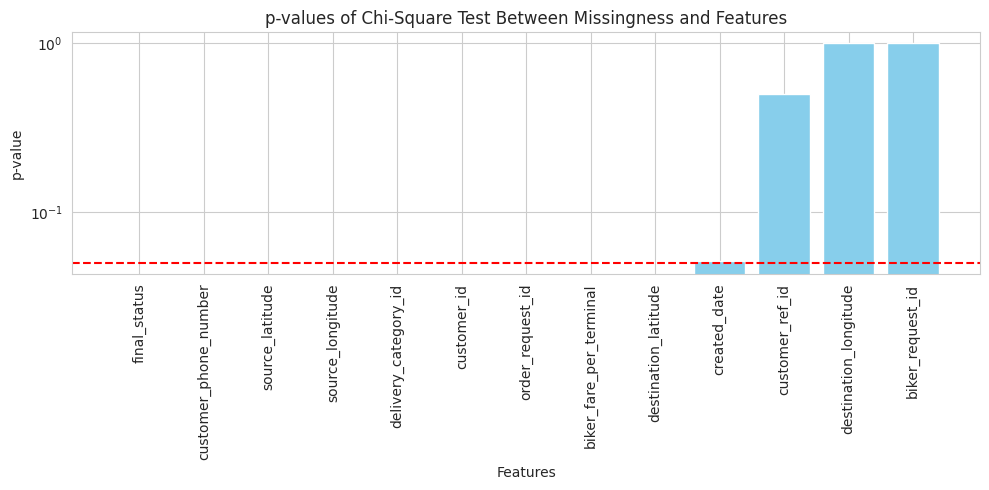

In [26]:
results_df_sorted = pd.DataFrame(results).sort_values('p-value')
results_df_sorted['p-value'] = results_df_sorted['p-value'].apply(lambda p: 0 if p < 0.0001 else p)

# Plotting
plt.figure(figsize=(10, 5))
plt.bar(results_df_sorted['Feature'], results_df_sorted['p-value'], color='skyblue')
plt.axhline(y=0.05, color='r', linestyle='--')  # Threshold line for p-value=0.05
plt.xlabel('Features')
plt.ylabel('p-value')
plt.xticks(rotation=90)  # Rotate feature names for better visibility
plt.title('p-values of Chi-Square Test Between Missingness and Features')
plt.yscale('log')  # Optional: Use log scale if p-values vary widely
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels

# Show plot
plt.show()

In [27]:
df.loc[df['biker_phone_number'].isna(),'customer_phone_number'].value_counts()

customer_phone_number
v1Ten8pejx1wJup23jqrTQ==    358
0qabDebg/QgYtAdbErDsgw==    271
ssQGbAHze5YDkMegqgvxNQ==     84
uLJM3C6Ymbw0nPSYRH8mEg==     24
f68bAvk34EeQvpbr09MeHw==     18
                           ... 
92pV6k9UVND8s7UORsUwwg==      1
VYFUEmttP6EmXyIUJVRqLQ==      1
nAdETnP0Y+wEVPelkjFpuw==      1
q5wIxNKuf0PywURp1byTyw==      1
VxpSAHbBttXxVEQ6W2qxBw==      1
Name: count, Length: 110, dtype: int64

In [28]:
df[df['customer_phone_number']=='v1Ten8pejx1wJup23jqrTQ==']

,created_date,customer_id,biker_request_id,biker_phone_number,order_request_id,delivery_category_id,customer_ref_id,final_status,biker_fare_per_terminal,customer_phone_number,destination_longitude,destination_latitude,source_latitude,source_longitude,missing_indicator
10960,2023-08-11,2,3281831.0,lVTlYsqoxRoNXcOxRj3SAA==,474713234,0,425441119,DELIVERED,3.033333e+05,v1Ten8pejx1wJup23jqrTQ==,27.353533,21.350968,21.353258,27.355208,0
10961,2023-08-11,2,1311519.0,fi0aFyEUVnEBrVoeTHFxMw==,476001263,0,425409545,DELIVERED,1.000000e+05,v1Ten8pejx1wJup23jqrTQ==,27.353620,21.379226,21.376601,27.348835,0
10962,2023-08-11,2,1609236.0,H5ysuOCEdWM6q0BKzIkkgQ==,473977818,0,425474489,DELIVERED,1.350000e+06,v1Ten8pejx1wJup23jqrTQ==,27.378474,21.361393,21.359502,27.374965,0
10963,2023-08-11,2,2167232.0,zB/2UWqHwbTuXvqfFniwLg==,472004948,0,425443190,DELIVERED,4.500000e+05,v1Ten8pejx1wJup23jqrTQ==,27.369234,21.359992,21.365173,27.371015,0
10964,2023-08-11,2,1365764.0,FCUVS0JHIm+3dBhAfJSTcw==,475893159,0,425473321,DELIVERED,5.000000e+05,v1Ten8pejx1wJup23jqrTQ==,27.338552,21.361941,21.364451,27.337753,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134357,2023-08-11,2,3291269.0,yK1MyAaJpeQcnspK0dkBcQ==,474582796,0,425493340,DELIVERED,1.575000e+06,v1Ten8pejx1wJup23jqrTQ==,27.346322,21.379864,21.373248,27.344940,0
134358,2023-08-11,2,2705694.0,QaP1Ehrjp9Ex84BF72a6Sg==,475837810,0,425468848,DELIVERED,3.200000e+05,v1Ten8pejx1wJup23jqrTQ==,27.360276,21.361340,21.360585,27.360981,0
134359,2023-08-11,2,2749432.0,jCBVXnYxUE5Mn3Ls3lo1sg==,473744625,0,425481688,DELIVERED,1.200000e+05,v1Ten8pejx1wJup23jqrTQ==,27.355467,21.362301,21.363404,27.354166,0
134360,2023-08-11,2,1503164.0,VC6Nuk2Jtk5fOrKd/NmDBQ==,478375574,0,425394209,DELIVERED,3.487500e+05,v1Ten8pejx1wJup23jqrTQ==,27.356045,21.364237,21.363243,27.356254,0


In [29]:
df.loc[df['biker_phone_number'].isna(),'final_status'].value_counts()

final_status
CANCELLED    1216
DELIVERED       8
Name: count, dtype: int64

In [30]:
df['distance'] = df[['destination_latitude','destination_longitude','source_latitude','source_longitude']].apply(lambda x:haversine((x[0],x[1]), (x[2],x[3]),unit='m'),axis = 1 ) 
fraud['distance'] = fraud[['destination_latitude','destination_longitude','source_latitude','source_longitude']].apply(lambda x:haversine((x[0],x[1]), (x[2],x[3]),unit='m'),axis = 1 ) 

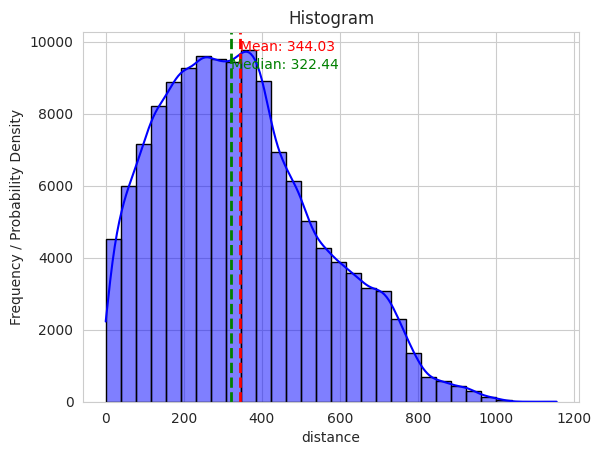

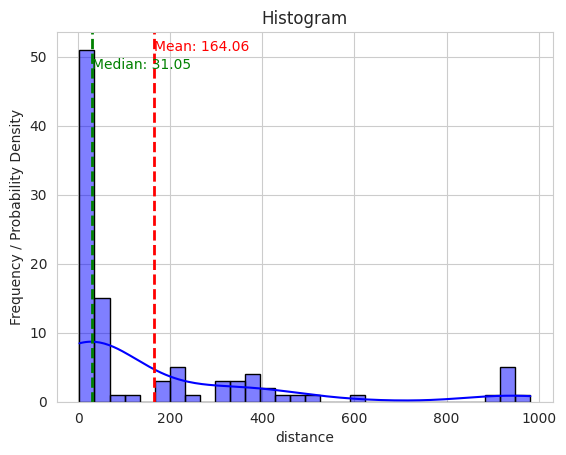

In [88]:
histogram_plot(df['distance'],'distance',statistics=True,kde = True)
histogram_plot(fraud['distance'],'distance',statistics=True, kde = True)

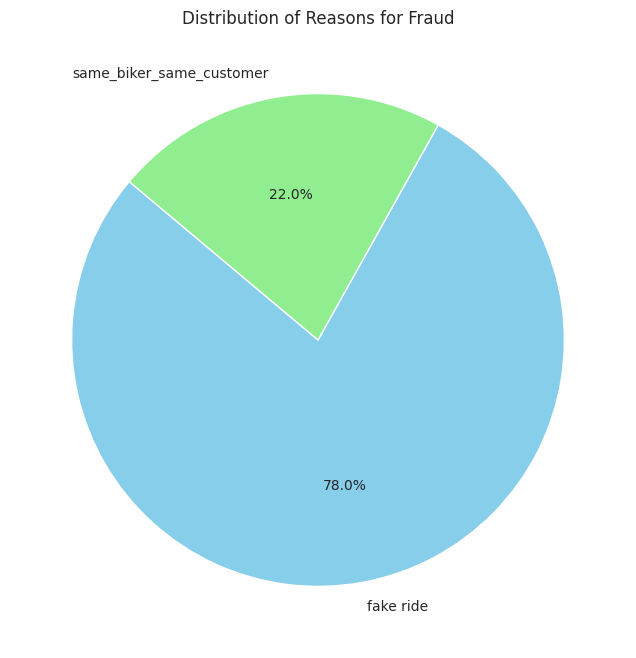

In [32]:
value_counts = fraud['reason'].value_counts()
plt.figure(figsize=(8, 8))  # Set the figure size for better readability
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightgreen'])
plt.title('Distribution of Reasons for Fraud')  # Customize the title as needed
plt.show()

## Dropping Missing values and adding fraud data as lable to the dateset

In [33]:
df.dropna(inplace = True)

In [34]:
df['fraud'] = 0
df.loc[df['customer_ref_id'].isin(fraud['customer_ref_id']),'fraud'] = 1
df['fraud'].value_counts()

fraud
0    133051
1        87
Name: count, dtype: int64

In [35]:
df.drop(columns=['created_date','final_status','customer_ref_id','order_request_id'],inplace = True       )

In [36]:
fraud.drop(columns = ['Unnamed: 0','created_date','customer_ref_id','city'],inplace = True)

In [37]:
df.columns

Index(['customer_id', 'biker_request_id', 'biker_phone_number',
       'delivery_category_id', 'biker_fare_per_terminal',
       'customer_phone_number', 'destination_longitude',
       'destination_latitude', 'source_latitude', 'source_longitude',
       'missing_indicator', 'distance', 'fraud'],
      dtype='object')

/tmp/ipykernel_220473/2908863727.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  scatter = sb.scatterplot(data=df, x="fraud", y="biker_fare_per_terminal", palette="deep", s=100)


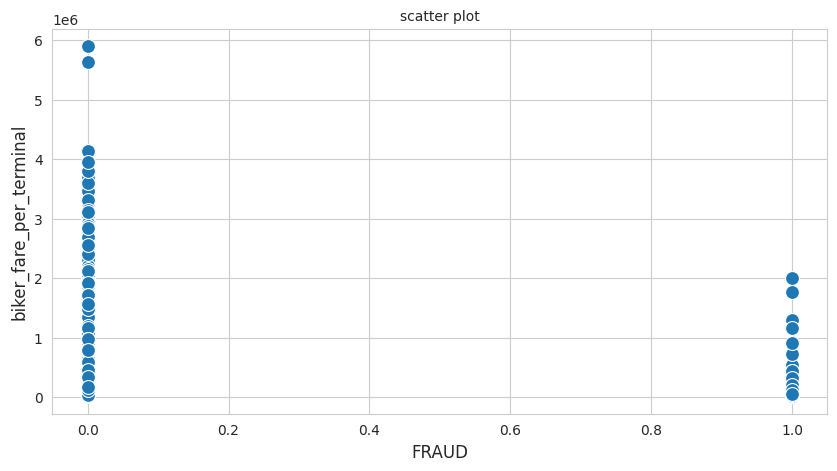

In [38]:
sb.set_style("whitegrid")

plt.figure(figsize=(10, 5))
scatter = sb.scatterplot(data=df, x="fraud", y="biker_fare_per_terminal", palette="deep", s=100)

scatter.set_title('scatter plot', fontsize=10)
scatter.set_xlabel('FRAUD', fontsize=12)
scatter.set_ylabel('biker_fare_per_terminal', fontsize=12)


plt.show()

In [39]:
fraud[(fraud['biker_fare_per_terminal']>1e6)]

,customer_id,reason,biker_request_id,biker_phone_number,order_request_id,delivery_category,final_status,biker_fare_per_terminal,customer_phone_number,destination_longitude,destination_latitude,source_latitude,source_longitude,distance
25,2,fake ride,2820768,3M5PBEi5Cmj5n90iT8CXDQ==,476470624,bike,DELIVERED,1597500.0,qgHjDa8RjOvGzF/jOYoZew==,27.353653,21.363436,21.366327,27.356286,421.524990
48,14109185,fake ride,2182277,vUBSmHoJEgpJ2XLxWHy9vQ==,478176455,bike-without-box,DELIVERED,1012500.0,FxwvvviyH92YDLAlClzDMQ==,27.378090,21.347094,21.344939,27.369317,939.706330
72,14109185,fake ride,2303626,b4whN1ceYwbJowlxbmlVbQ==,474863821,bike-without-box,DELIVERED,1350000.0,8UTzn/zFJSNMrYSUP8W2Yg==,27.378082,21.347097,21.344939,27.369317,939.012943
73,2,same_biker_same_customer,1561839,rgVLjJkdchGQgFYn/71n/w==,469221363,bike,DELIVERED,1600000.0,rgVLjJkdchGQgFYn/71n/w==,27.353648,21.363402,21.363404,27.354166,53.626897
99,14109185,fake ride,2794923,Zg6+xVcFhcumaeskM1Wa/A==,469493703,bike-without-box,DELIVERED,1125000.0,fsnx34sHzTzGRc+Na4P1Qw==,27.378081,21.347104,21.344939,27.369317,939.117000


In [40]:
df['biker_fare_per_terminal_normalized'] = np.log(df['biker_fare_per_terminal'])
z_stat, p_value = ztest(df.loc[df['fraud']==1,'biker_fare_per_terminal'], df.loc[df['fraud']==0,'biker_fare_per_terminal'].sample(10000))

print(f'Z-statistic: {z_stat}')
print(f'P-value: {p_value}')

Z-statistic: -2.6814884174473455
P-value: 0.007329545170385499


In [41]:

z_stat, p_value = ztest(df.loc[df['fraud']==1,'distance'], df.loc[df['fraud']==0,'distance'].sample(100))

print(f'Z-statistic: {z_stat}')
print(f'P-value: {p_value}')

Z-statistic: -7.897802378416681
P-value: 2.838637380579191e-15


## Check if we can train a model for fraud detection using random forest

In [42]:
from sklearn.preprocessing import LabelEncoder

import category_encoders as ce

le = LabelEncoder()
le.fit(df['biker_phone_number'].tolist()+df['customer_phone_number'].tolist() )
df['customer_phone_number'] = le.transform(df[ 'customer_phone_number'])
df['biker_phone_number'] = le.transform(df[ 'biker_phone_number'])

In [43]:
non_fraud=df[df['fraud']==0].sample(1000)
X = pd.concat([non_fraud.reset_index(),df[df['fraud']==1].reset_index()])
y = X['fraud']
X= X.drop(columns = [ 'customer_id', 'biker_request_id','biker_fare_per_terminal_normalized', 'fraud'])

In [44]:
X_res, y_res = RandomOverSampler(random_state=42).fit_resample(X, y)
X_res = X_res.drop(columns= ['index'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

rf_clf = RandomForestClassifier(random_state=42,n_estimators=100,max_depth=10)

rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        99
           1       1.00      0.70      0.82        10

    accuracy                           0.97       109
   macro avg       0.99      0.85      0.90       109
weighted avg       0.97      0.97      0.97       109



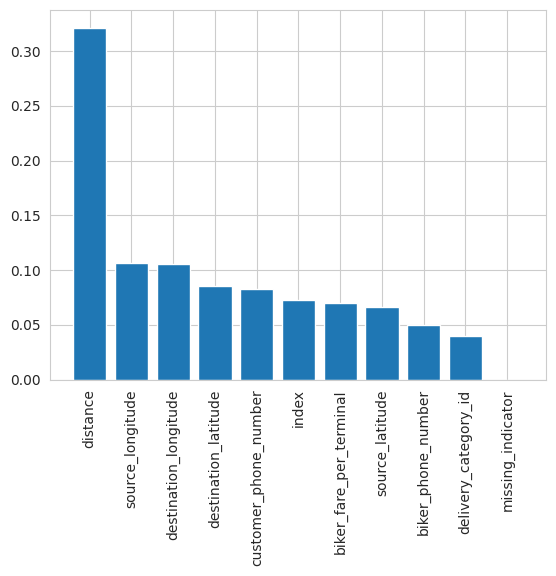

In [45]:
feature_importances = rf_clf.feature_importances_

importances_series = pd.Series(feature_importances, index=X_train.columns).sort_values(ascending=False)

plt.bar(importances_series.index,importances_series)
plt.xticks(rotation=90);


## Clustering on the entire dataset to check for anomalies

In [46]:
df.columns

Index(['customer_id', 'biker_request_id', 'biker_phone_number',
       'delivery_category_id', 'biker_fare_per_terminal',
       'customer_phone_number', 'destination_longitude',
       'destination_latitude', 'source_latitude', 'source_longitude',
       'missing_indicator', 'distance', 'fraud',
       'biker_fare_per_terminal_normalized'],
      dtype='object')

In [47]:
df = df.reset_index().drop(columns = 'index')

In [48]:
data = df.copy()
data= data.drop(columns = [ 'customer_id', 'biker_request_id','fraud'
                        ,'missing_indicator','biker_fare_per_terminal_normalized'])


In [49]:
encoder = ce.BinaryEncoder(cols=['biker_phone_number','customer_phone_number'])
X = encoder.fit_transform(data)

In [50]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
features_to_normalize = ['distance','biker_fare_per_terminal']
X[features_to_normalize] = sc.fit_transform(X[features_to_normalize])

In [51]:

resolution = 12
X['source_clusters'] = X.loc[:,['source_latitude','source_longitude']].apply(lambda x: h3.geo_to_h3(x[0], x[1], resolution),axis = 1)
X['destination_clusters'] = X.loc[:,['destination_latitude','destination_longitude']].apply(lambda x: h3.geo_to_h3(x[0], x[1], resolution),axis = 1)

le = LabelEncoder()
le = LabelEncoder()
le.fit(X['source_clusters'].tolist()+X['destination_clusters'].tolist() )
X['source_clusters'] = le.transform(X[ 'source_clusters'])
X['destination_clusters'] = le.transform(X[ 'destination_clusters'])

In [86]:
X['destination_clusters'] = DBSCAN(eps=.0001,min_samples=2).fit(X[['destination_longitude','destination_latitude']]).labels_
X['source_clusters'] = DBSCAN(eps=.0001,min_samples=2).fit(X[['source_latitude','source_longitude']]).labels_

In [52]:
encoder = ce.BinaryEncoder(cols=['destination_clusters','source_clusters'])
X = encoder.fit_transform(X)

In [53]:
X.columns

Index(['biker_phone_number_0', 'biker_phone_number_1', 'biker_phone_number_2',
       'biker_phone_number_3', 'biker_phone_number_4', 'biker_phone_number_5',
       'biker_phone_number_6', 'biker_phone_number_7', 'biker_phone_number_8',
       'biker_phone_number_9', 'biker_phone_number_10',
       'biker_phone_number_11', 'delivery_category_id',
       'biker_fare_per_terminal', 'customer_phone_number_0',
       'customer_phone_number_1', 'customer_phone_number_2',
       'customer_phone_number_3', 'customer_phone_number_4',
       'customer_phone_number_5', 'customer_phone_number_6',
       'customer_phone_number_7', 'destination_longitude',
       'destination_latitude', 'source_latitude', 'source_longitude',
       'distance', 'source_clusters_0', 'source_clusters_1',
       'source_clusters_2', 'source_clusters_3', 'source_clusters_4',
       'source_clusters_5', 'source_clusters_6', 'source_clusters_7',
       'source_clusters_8', 'source_clusters_9', 'source_clusters_10',
      

In [54]:
X= X.drop(columns = [ 'destination_longitude', 'destination_latitude', 'source_latitude',   'source_longitude'])


Text(0, 0.5, 'explained_variance_ratio')

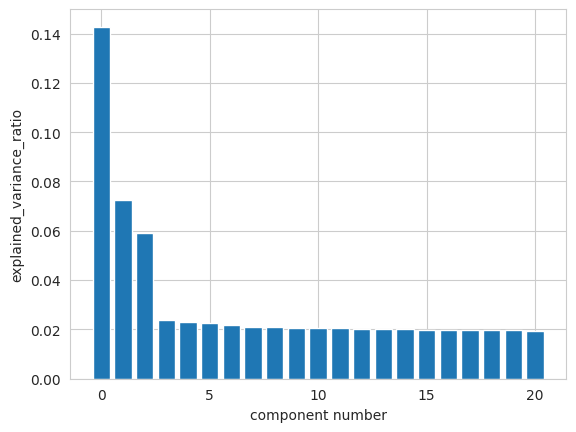

In [55]:
from sklearn.decomposition import PCA
pca = PCA(n_components=21, svd_solver='arpack')
pca.fit(X)
plt.bar(range(0,len(pca.explained_variance_ratio_)),pca.explained_variance_ratio_)
plt.xlabel('component number')
plt.ylabel('explained_variance_ratio')

In [56]:
X_transformed = PCA(n_components=3, svd_solver='arpack').fit_transform(X)

In [57]:
X_transformed.shape

(133138, 3)

In [58]:
X_transformed = pd.DataFrame(X_transformed,columns=['col'+str(i) for i in range(1,X_transformed.shape[1]+1)])

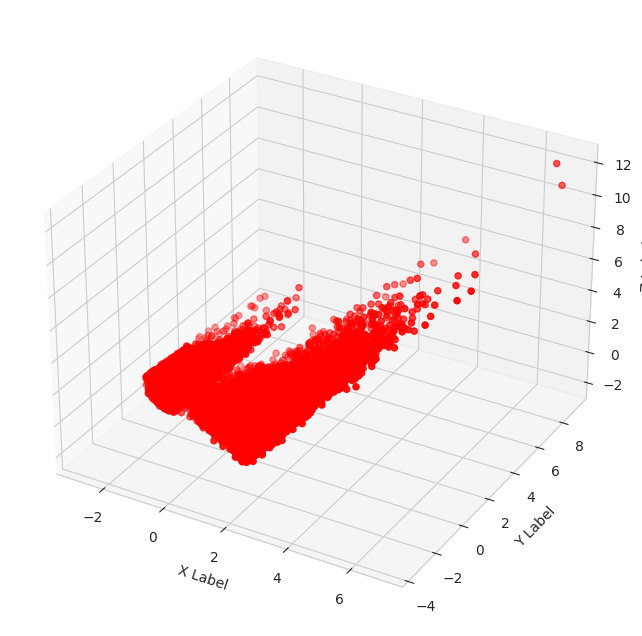

In [59]:
sb.set_style("whitegrid")

# Create a new matplotlib figure and 3D axis
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using the sample data
ax.scatter(X_transformed['col1'], X_transformed['col3'], X_transformed['col2'], c='r', marker='o')  # 'c' is the color and 'marker' is the shape of points

# Setting labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# Display the plot
plt.show()

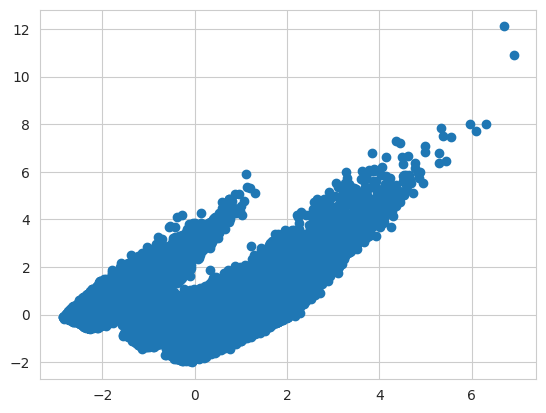

In [60]:
plt.scatter(X_transformed['col1'], X_transformed['col2'])

In [78]:
df[(X_transformed['col1']>5)&(X_transformed['col2']>6)]  ## high fare

,customer_id,biker_request_id,biker_phone_number,delivery_category_id,biker_fare_per_terminal,customer_phone_number,destination_longitude,destination_latitude,source_latitude,source_longitude,missing_indicator,distance,fraud,biker_fare_per_terminal_normalized,label
27432,2,1515596.0,2543,0,3800000.0,3359,27.384066,21.364522,21.355826,27.384542,0,968.217577,0,15.150512,-1
38355,2,2706261.0,41,0,5625000.0,3359,27.353647,21.363426,21.361429,27.356317,0,354.642195,0,15.542732,-1
66411,2,2738193.0,1268,0,4140000.0,3359,27.353656,21.363457,21.366486,27.356314,0,434.995495,0,15.236206,-1
84434,2,2226479.0,276,0,3060000.0,3359,27.336528,21.379548,21.370719,27.337804,0,990.593775,0,14.933925,-1
103493,2,2121404.0,1279,0,3690000.0,3359,27.343422,21.385700,21.378974,27.343154,0,748.435043,0,15.121137,-1
121126,2,1975880.0,563,0,3150000.0,3359,27.357927,21.349738,21.356917,27.360832,0,853.090919,0,14.962913,-1
121426,2,2226723.0,2623,0,3600000.0,3359,27.351580,21.357335,21.366426,27.350763,0,1014.472213,0,15.096444,-1
121608,2,1701234.0,604,0,3320000.0,3359,27.345823,21.363712,21.363480,27.353793,0,825.680293,0,15.015475,-1
130205,2,2783992.0,1370,0,3800000.0,3359,27.360778,21.359649,21.360747,27.366854,0,640.990899,0,15.150512,-1
130212,2,3009149.0,430,0,3955000.0,3359,27.352370,21.359488,21.353258,27.355208,0,752.492355,0,15.190491,-1


In [62]:
df[(X_transformed['col1']>6)&(X_transformed['col2']>10)]  ## high fare, same customer phone number but different location

,customer_id,biker_request_id,biker_phone_number,delivery_category_id,biker_fare_per_terminal,customer_phone_number,destination_longitude,destination_latitude,source_latitude,source_longitude,missing_indicator,distance,fraud,biker_fare_per_terminal_normalized
38355,2,2706261.0,41,0,5625000.0,3359,27.353647,21.363426,21.361429,27.356317,0,354.642195,0,15.542732
131574,2,2889865.0,1848,1,5895000.0,3359,27.353661,21.363465,21.366308,27.356380,0,423.346021,0,15.589615


## Cluster the data output from PCA to identify the similar group of patterns

In [63]:
df['label']  = DBSCAN(eps=.4,min_samples=2).fit(X_transformed).labels_

In [90]:
kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(X_transformed)
df['label'] = kmeans.predict(X_transformed)

In [64]:
df.groupby('label')['fraud'].sum()

label
-1      0
 0     86
 1      0
 2      0
 3      0
 4      0
 5      0
 6      0
 7      0
 8      0
 9      0
 10     0
 11     0
 12     1
 13     0
Name: fraud, dtype: int64

In [65]:
df.shape

(133138, 15)

In [66]:
X_transformed.shape

(133138, 3)

0 0
1 1
2 2
3 3
4 4
5 -1
6 5
7 6
8 7
9 8
10 9
11 10
12 11
13 12
14 13


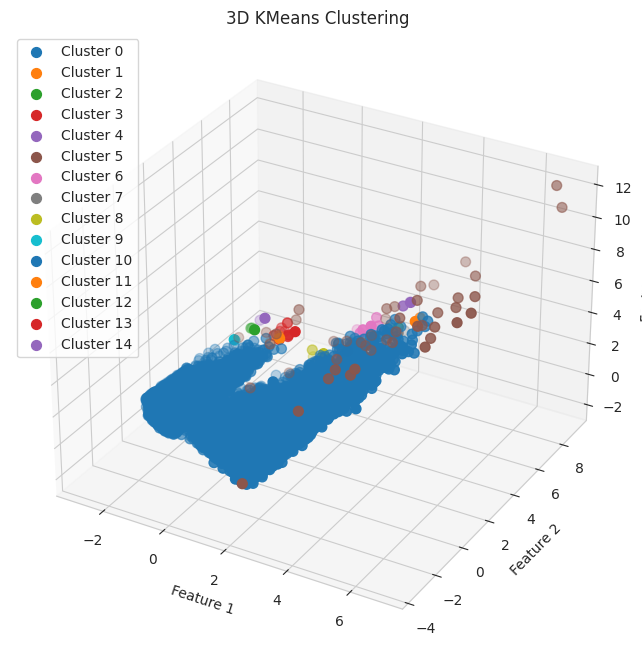

In [69]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
#colors = ['red', 'blue', 'green', 'purple', 'orange', 'cyan', 'magenta', 'yellow', 'lime', 'pink']
labels = df['label'].unique()
for i in range(len(labels)):
    print(i,labels[i])
    ax.scatter(X_transformed.loc[df['label']==labels[i], 'col1'], X_transformed.loc[df['label']==labels[i], 'col3'],
               X_transformed.loc[df['label']==labels[i],'col2'], 
                label=f'Cluster {i}', s=50)

# Scatter plot for the centroids of the clusters
#centers = kmeans.cluster_centers_
#ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c='red', s=200, alpha=0.5, marker='o')

ax.set_title('3D KMeans Clustering')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
ax.legend()
# Show the plot
plt.show()

In [70]:
df[df['label']==-1]  # same biker for the same customer 

,customer_id,biker_request_id,biker_phone_number,delivery_category_id,biker_fare_per_terminal,customer_phone_number,destination_longitude,destination_latitude,source_latitude,source_longitude,missing_indicator,distance,fraud,biker_fare_per_terminal_normalized,label
6107,11653225,1868051.0,441,0,1.057500e+06,66,27.365334,21.362490,21.362435,27.368712,0,349.953725,0,13.871418,-1
6347,11653225,2649607.0,3343,2,1.840000e+06,1269,27.180646,21.334624,21.335718,27.181834,0,173.033190,0,14.425276,-1
20017,11653225,1536589.0,312,2,2.480000e+06,1202,27.361243,21.359740,21.358255,27.365170,0,438.858312,0,14.723769,-1
20780,11653225,4266603.0,1305,2,2.030000e+06,479,27.347516,21.363324,21.366084,27.351819,0,541.089007,0,14.523546,-1
25471,2,2128165.0,1970,0,1.083333e+05,3359,27.336001,21.367528,21.365077,27.346847,0,1155.798915,0,11.592968,-1
27254,2,1856567.0,1015,1,1.400000e+06,3359,27.344558,21.364836,21.364936,27.344013,0,57.525545,0,14.151983,-1
27432,2,1515596.0,2543,0,3.800000e+06,3359,27.384066,21.364522,21.355826,27.384542,0,968.217577,0,15.150512,-1
27545,2,2015175.0,3522,1,2.295000e+06,3359,27.374975,21.352541,21.352919,27.372789,0,230.206185,0,14.646243,-1
27557,2,1847403.0,1059,1,2.300000e+06,3359,27.364277,21.360551,21.369609,27.363104,0,1014.481598,0,14.648420,-1
28423,2,2710161.0,3269,1,3.080000e+06,3359,27.337291,21.369723,21.366463,27.338405,0,380.479167,0,14.940440,-1


In [72]:
df[df['label']==12]

,customer_id,biker_request_id,biker_phone_number,delivery_category_id,biker_fare_per_terminal,customer_phone_number,destination_longitude,destination_latitude,source_latitude,source_longitude,missing_indicator,distance,fraud,biker_fare_per_terminal_normalized,label
67014,2,1561839.0,3174,0,2000000.0,3359,27.353648,21.363402,21.363404,27.354166,0,53.591606,1,14.508658,12
103722,2,2968123.0,1919,0,2000000.0,3359,27.353638,21.363419,21.363404,27.354166,0,54.661074,0,14.508658,12
122629,2,2706261.0,41,0,2100000.0,3359,27.353656,21.363457,21.363404,27.354166,0,53.058555,0,14.557448,12


In [75]:
df[df['label']==13]

,customer_id,biker_request_id,biker_phone_number,delivery_category_id,biker_fare_per_terminal,customer_phone_number,destination_longitude,destination_latitude,source_latitude,source_longitude,missing_indicator,distance,fraud,biker_fare_per_terminal_normalized,label
84548,2,3040323.0,3313,0,3200000.0,3359,27.353626,21.363306,21.363404,27.354166,0,56.955526,0,14.978661,13
113163,2,2968123.0,1919,0,3200000.0,3359,27.353627,21.363410,21.363404,27.354166,0,55.735235,0,14.978661,13
132977,2,2865814.0,2977,0,3105000.0,3359,27.353630,21.363335,21.363404,27.354166,0,55.985456,0,14.948524,13


In [76]:
df[df['label']==8] # low distance with similar source-destination

,customer_id,biker_request_id,biker_phone_number,delivery_category_id,biker_fare_per_terminal,customer_phone_number,destination_longitude,destination_latitude,source_latitude,source_longitude,missing_indicator,distance,fraud,biker_fare_per_terminal_normalized,label
41187,11653225,2173010.0,3405,2,1440000.0,2493,27.371980,21.358646,21.358713,27.372022,0,8.63405,0,14.180154,8
41794,11653225,1868051.0,441,2,1440000.0,2493,27.371978,21.358649,21.358713,27.372022,0,8.41336,0,14.180154,8


## Analysis of impact of distance on different reasons of Fraud

In [53]:
fraud['distance'] = fraud[['destination_latitude','destination_longitude','source_latitude','source_longitude']].apply(lambda x:haversine((x[0],x[1]), (x[2],x[3]),unit='m'),axis = 1 ) 

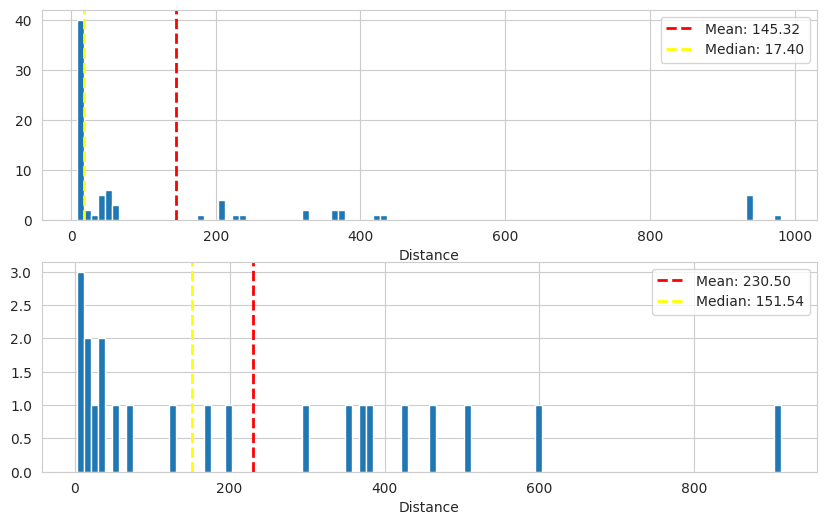

In [54]:

plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.hist(fraud.loc[fraud['reason']=='fake ride','distance'],bins=100);
plt.xlabel('Distance')
mean_value = np.mean(fraud.loc[fraud['reason']=='fake ride','distance'])
median_values= np.median(fraud.loc[fraud['reason']=='fake ride','distance'])

plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(median_values, color='yellow', linestyle='dashed', linewidth=2, label=f'Median: {median_values:.2f}')
plt.legend()



plt.subplot(2,1,2)
plt.hist(fraud.loc[fraud['reason']=='same_biker_same_customer','distance'],bins=100);
plt.xlabel('Distance')

mean_value = np.mean(fraud.loc[fraud['reason']=='same_biker_same_customer','distance'])
median_values= np.median(fraud.loc[fraud['reason']=='same_biker_same_customer','distance'])

plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(median_values, color='yellow', linestyle='dashed', linewidth=2, label=f'Median: {median_values:.2f}')
plt.legend()

In [46]:
fraud[(fraud['biker_phone_number']!=fraud['customer_phone_number']) & (fraud['reason']=='same_biker_same_customer')]

,customer_id,reason,biker_request_id,biker_phone_number,order_request_id,delivery_category,final_status,biker_fare_per_terminal,customer_phone_number,destination_longitude,destination_latitude,source_latitude,source_longitude,distance
8,2,same_biker_same_customer,2705694,QaP1Ehrjp9Ex84BF72a6Sg==,474218198,bike,DELIVERED,204166.666667,5CThdFAibm0aKDs5F/iR2g==,27.36067,21.360181,21.360219,27.360387,29.607509


## Analysis of the possibility of having bikers which only give service to a single customer

In [47]:
delivery_counts = df.groupby(['biker_phone_number', 'customer_phone_number']).size().reset_index(name='count')

threshold_met = delivery_counts[delivery_counts['count'] >= 50]

biker_unique_customers = threshold_met.groupby('biker_phone_number')['customer_phone_number'].nunique()

bikers_single_customer = biker_unique_customers[biker_unique_customers == 1].index

threshold_met[threshold_met['biker_phone_number'].isin(bikers_single_customer)]

,biker_phone_number,customer_phone_number,count
148,+nwJdXpBaO3pqSyVo5ycJQ==,v1Ten8pejx1wJup23jqrTQ==,149
166,+tLiioThABUz+FdPfm0kJw==,v1Ten8pejx1wJup23jqrTQ==,54
242,/P1qv6vQd0Nn8B+KcHXWQA==,v1Ten8pejx1wJup23jqrTQ==,131
279,/WyokkA96i0v6PxmIm963Q==,v1Ten8pejx1wJup23jqrTQ==,51
286,/cN3O5Jz8/C2EAK062BtMA==,v1Ten8pejx1wJup23jqrTQ==,91
...,...,...,...
15822,zW5HvapiBXy03bLp7Jtqpw==,v1Ten8pejx1wJup23jqrTQ==,59
15910,zop1Q0Edjleh9Fm+87ds9w==,v1Ten8pejx1wJup23jqrTQ==,228
15939,zrhv/JhqykdOX1dd/cpocg==,v1Ten8pejx1wJup23jqrTQ==,95
15946,zsMVttBLjdYaXHaDRGwCkw==,v1Ten8pejx1wJup23jqrTQ==,97


In [48]:
delivery_counts = df.groupby(['biker_phone_number', 'customer_phone_number']).size().reset_index(name='count')

threshold_met = delivery_counts[delivery_counts['count'] >= 50]

biker_unique_customers = threshold_met.groupby('customer_phone_number')['biker_phone_number'].nunique()

bikers_single_customer = biker_unique_customers[biker_unique_customers == 1].index

threshold_met[threshold_met['customer_phone_number'].isin(bikers_single_customer)]

,biker_phone_number,customer_phone_number,count
633,0nK3EEpBmdMpNgxR5O1q9Q==,f68bAvk34EeQvpbr09MeHw==,58
7473,RlAnPzvRLaprIHTtIQ3D0g==,uLJM3C6Ymbw0nPSYRH8mEg==,51
7946,UHbER/z6etIHTjuT289ZFg==,lrfHNd0OXD0OlkM3CTdZlg==,63
12213,lLE7lJh/yTk3VnJ28Msgyg==,xhQRAXgHpthAadwslIQ0iw==,94
12839,noCb6VzdDSO08Lijf8y9VQ==,S9bXBKI9WgMG8ethhEFhGQ==,53
14476,uQhFHvSFb+RKQlMks8aT4Q==,6Tc5rHViatLAp34WBy6SWw==,57


In [49]:
fraud.head()

,customer_id,reason,biker_request_id,biker_phone_number,order_request_id,delivery_category,final_status,biker_fare_per_terminal,customer_phone_number,destination_longitude,destination_latitude,source_latitude,source_longitude,distance
0,2,same_biker_same_customer,2997747,DdYkRZO6s/7+wAqt/ykX4Q==,476519902,big-box,DELIVERED,162500.000000,DdYkRZO6s/7+wAqt/ykX4Q==,27.374180,21.347616,21.347160,27.368386,602.236454
1,11653225,fake ride,2948946,ELJeQx5rxhhEmfHwgA5OYw==,477901383,bike-without-box,DELIVERED,180000.000000,fAhijISaQLNNfvt2Epm7Lw==,27.372249,21.363878,21.363502,27.372126,43.704098
2,14109185,fake ride,2996281,Ye3KL4SuOSsObrqLQEpzmw==,472410620,bike-without-box,DELIVERED,413333.333333,ql+OWn4d094Dv+qGekHDyg==,27.366596,21.353237,21.353792,27.366384,65.417345
3,11653225,fake ride,2007528,F9W4mmmFG3vs3WYeRlmx8g==,472812665,bike-without-box,DELIVERED,80000.000000,qZTnfP8YOg40wBZ2DnB57w==,27.368057,21.351640,21.351580,27.368103,8.124666
4,11653225,fake ride,3209726,s1FugjWvloZA+ZftOJmFJQ==,475974765,bike-without-box,DELIVERED,160000.000000,6xiri9b2vdfrbLxkZLkIZw==,27.367335,21.364569,21.364643,27.367372,9.110205


In [53]:
delivery_counts = fraud.groupby(['biker_phone_number', 'customer_phone_number']).size().reset_index(name='count')

threshold_met = delivery_counts[delivery_counts['count'] >= 2]

biker_unique_customers = threshold_met.groupby('biker_phone_number')['customer_phone_number'].nunique()

bikers_single_customer = biker_unique_customers[biker_unique_customers == 1].index

threshold_met[threshold_met['biker_phone_number'].isin(bikers_single_customer)]

,biker_phone_number,customer_phone_number,count
49,VyCedaOwna5fSRQWNvpB7g==,VyCedaOwna5fSRQWNvpB7g==,3
57,Ye3KL4SuOSsObrqLQEpzmw==,ql+OWn4d094Dv+qGekHDyg==,2
77,rgVLjJkdchGQgFYn/71n/w==,rgVLjJkdchGQgFYn/71n/w==,2


In [55]:
fraud[fraud['biker_phone_number']=='Ye3KL4SuOSsObrqLQEpzmw==']

,customer_id,reason,biker_request_id,biker_phone_number,order_request_id,delivery_category,final_status,biker_fare_per_terminal,customer_phone_number,destination_longitude,destination_latitude,source_latitude,source_longitude,distance
2,14109185,fake ride,2996281,Ye3KL4SuOSsObrqLQEpzmw==,472410620,bike-without-box,DELIVERED,413333.333333,ql+OWn4d094Dv+qGekHDyg==,27.366596,21.353237,21.353792,27.366384,65.417345
74,14109185,fake ride,2996281,Ye3KL4SuOSsObrqLQEpzmw==,476865656,bike-without-box,DELIVERED,312500.000000,ql+OWn4d094Dv+qGekHDyg==,27.366596,21.353237,21.353792,27.366384,65.417345


In [56]:
fraud[fraud['biker_phone_number']=='rgVLjJkdchGQgFYn/71n/w==']

,customer_id,reason,biker_request_id,biker_phone_number,order_request_id,delivery_category,final_status,biker_fare_per_terminal,customer_phone_number,destination_longitude,destination_latitude,source_latitude,source_longitude,distance
62,2,same_biker_same_customer,1561839,rgVLjJkdchGQgFYn/71n/w==,475294449,bike,DELIVERED,1.183333e+05,rgVLjJkdchGQgFYn/71n/w==,27.353648,21.363402,21.366308,27.356381,429.506826
73,2,same_biker_same_customer,1561839,rgVLjJkdchGQgFYn/71n/w==,469221363,bike,DELIVERED,1.600000e+06,rgVLjJkdchGQgFYn/71n/w==,27.353648,21.363402,21.363404,27.354166,53.626897


In [57]:
df.head()

,customer_id,biker_request_id,biker_phone_number,delivery_category_id,biker_fare_per_terminal,customer_phone_number,destination_longitude,destination_latitude,source_latitude,source_longitude,distance,fraud,biker_fare_per_terminal_normalized
0,11653225,1305684.0,f0xsz+2AwzyE5upJoZiRPg==,2,110000.0,IJ/G/FCku4VmMc0ysmeljQ==,27.182306,21.339714,21.335510,27.184477,518.705224,0,11.608236
1,11653225,17520.0,HhcTOAXS3fjGB8qV56pvsA==,2,180000.0,bcTH3WaJCXBpue89a8nY/Q==,27.346241,21.374972,21.372564,27.347296,289.154374,0,12.100712
2,11653225,2642406.0,MsBIgqhcHug2ABwrs/NpBw==,2,40000.0,Zu0mYA6iyC/YKiweS93tqg==,27.184062,21.331320,21.331901,27.183952,65.686053,0,10.596635
3,11653225,2909573.0,sMFPNzhcZLFq5qUlA6hkYg==,2,345000.0,0qabDebg/QgYtAdbErDsgw==,27.345351,21.376528,21.376674,27.350910,575.811179,0,12.751300
4,11653225,2285206.0,rPKRNUD0f0ivPb5PIxIVNw==,2,420000.0,0qabDebg/QgYtAdbErDsgw==,27.383733,21.349205,21.346586,27.385021,320.259971,0,12.948010


In [101]:
df['destination_clusters'] = DBSCAN(eps=.00001,min_samples=1).fit(df[['destination_longitude','destination_latitude']]).labels_

In [99]:
df['source_clusters'] = DBSCAN(eps=.0001,min_samples=10).fit(df[['source_latitude','source_longitude']]).labels_

In [102]:
df.groupby(['source_clusters','destination_clusters']).size().reset_index(name = 'count').sort_values('count',ascending = False)

,source_clusters,destination_clusters,count
5148,9,6065,146
40217,120,1205,136
38920,110,30474,119
31641,82,6022,66
43810,151,6023,61
...,...,...,...
41515,128,26567,1
41514,128,26472,1
41512,128,26189,1
41511,128,25495,1
